In [1]:
from pathlib import Path
import os

if Path.cwd().name != 'src':
    os.chdir('/home/vaschetti/maxarSrc/src')

Print all the events' name

In [2]:
from my_functions.assemble import names
events_names = names.get_all_events()
for i, e_n in enumerate(events_names):
    print(i, e_n)

0 southafrica-flooding22
1 Kalehe-DRC-Flooding-5-8-23
2 shovi-georgia-landslide-8Aug23
3 Emilia-Romagna-Italy-flooding-may23
4 NWT-Canada-Aug-23
5 Libya-Floods-Sept-2023
6 Gambia-flooding-8-11-2022
7 New-Zealand-Flooding23
8 Hurricane-Fiona-9-19-2022
9 Hurricane-Idalia-Florida-Aug23
10 Hurricane-Ian-9-26-2022
11 yellowstone-flooding22
12 pakistan-flooding22
13 Morocco-Earthquake-Sept-2023
14 Indonesia-Earthquake22
15 cyclone-emnati22
16 Kahramanmaras-turkey-earthquake-23
17 Marshall-Fire-21-Update
18 India-Floods-Oct-2023
19 Maui-Hawaii-fires-Aug-23
20 tonga-volcano21
21 BayofBengal-Cyclone-Mocha-May-23
22 Sudan-flooding-8-22-2022


**Set some parameters** used in the segmentation phase, such as batch size and device. </br>
Also it instantiate both the **GroundingDino** model and the **Efficent SAM** model  

In [3]:
from my_functions.configs import SegmentConfig
config = SegmentConfig(batch_size = 2, device='cuda:1')

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased

- GD model device: cuda:1
- Efficient SAM device: cuda:1


Build an Event (e.g. 'Gambia-flooding-8-11-2022')</br>
Print its region and the names of its mosaics</br>
Print the number of tiles contained in the first mosaic


In [4]:
from my_functions.assemble import holders

event = holders.Event(events_names[6], seg_config = config, when='pre')
print(event.region_name)

all_mosaics_names = event.all_mosaics_names
print(all_mosaics_names)

m0 = event.mosaics[all_mosaics_names[0]]
print(f'Number of tiles: {m0.tiles_num}')


AfricaWest-Full
['10300100CFC9A500', '105001002BD68F00', '1040010073D77D00']
Number of tiles: 18


Set the geodataframe of the **building** of the first mosaic

In [6]:
m0.set_build_gdf()


Buildings: found 3 links matching: [33303200, 3330320, 333032]


Create the geodataframe of the **roads** of the first mosaic

In [7]:
m0.set_road_gdf()

Roads: reading roads for the whole AfricaWest-Full region
Roads: not in USA. Region name: AfricaWest-Full.tsv
Roads in 10300100CFC9A500 mosaic: 18325


In [8]:
from torchgeo.datasets import stack_samples
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from time import time
import warnings
import rasterio
import torch

from my_functions.samplers import samplers, samplers_utils
from my_functions.geo_datasets import geoDatasets
from my_functions.ESAM_segment import segment, segment_utils
from my_functions.detect import detect
from my_functions import output


# Ignore all warnings
warnings.filterwarnings('ignore')

Compute the trees, buildings and road mask for a whole tile

In [ ]:
m0.segment_tile(m0.tiles_paths[17], "/home/vaschetti/maxarSrc/output/tiff")

Otherwise, to get the numpy masks...

In [ ]:
#Trees and buildings
canvas = m0.seg_tree_and_build_tile(m0.tiles_paths[17])

#Eventually save the numpy masks
np.save('/home/vaschetti/maxarSrc/output/canvas_1.npy', canvas)

In [ ]:
#road
road_mask = m0.seg_road_tile(m0.tiles_paths[17], road_width_mt = 5)

Remove possible overlap between masks

In [ ]:
overlap_masks = np.concatenate((np.expand_dims(road_mask, axis=0), canvas[:-1]) , axis = 0)
no_overlap_masks = segment_utils.rmv_mask_overlap(overlap_masks)

Save to .tif

In [ ]:
names = ['road', 'tree', 'building']
for i, name in enumerate(names):
    out_name = 'second_try_whole_' + name + '.tif'
    output.single_mask2Tif(m0.tiles_paths[17], no_overlap_masks[i], out_name)

## End

In [ ]:
def seg_tree_and_build_tile(self, tile_path):
    seg_config = self.event.seg_config

    dataset = geoDatasets.MxrSingleTile(str(tile_path))
    sampler = samplers.WholeTifGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
    dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

    canvas = np.zeros((3,) + samplers_utils.tile_sizes(dataset), dtype=np.uint8) #dim (3, h_tile, w_tile). The first dim is: tree, build, pad
    
    all_batches_img_ixs = np.arange(len(sampler)*seg_config.batch_size).reshape((-1, seg_config.batch_size))
    _, total_cols = sampler.get_num_rows_cols()
    
    #f_i = 30
    
    #TIMERS
    GD_total = 0
    build_box_total = 0
    Esam_total = 0
    post_proc_total = 0
    
    start_time_all = time()
    for batch_ix, batch in tqdm(enumerate(dataloader), total = len(dataloader)):
        original_img_tsr = batch['image']
        img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor

        #trees
        #GD_t_0 = time()
        
        #get the tree boxes in batches and the number of trees for each image
        GD_start = time()
        tree_boxes_b, num_trees4img = detect.get_GD_boxes(img_b,
                                            seg_config.GD_model,
                                            seg_config.TEXT_PROMPT,
                                            seg_config.BOX_THRESHOLD,
                                            seg_config.TEXT_THRESHOLD,
                                            dataset.res,
                                            device = seg_config.device,
                                            max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
        GD_total += time() - GD_start
        #tree_boxes_b è una lista con degli array di shape (n, 4) dove n è il numero di tree boxes
        
        #print('GD_time: ', time() - GD_t_0)

        #get the building boxes in batches and the number of buildings for each image
        build_box_start = time()
        building_boxes_b, num_build4img = detect.get_batch_buildings_boxes(batch['bbox'],
                                                                    proj_buildings_gdf = self.proj_build_gdf,
                                                                    dataset_res = dataset.res,
                                                                    ext_mt = 10)
        build_box_total += time() - build_box_start
        
        #building_boxes_b è una lista con degli array di shape (n, 4) dove n è il numero di building boxes
        
        max_detect = max(num_trees4img + num_build4img)
        
        #print("\n__________________________")
        #print("Batch number: ", i)
        #print(f'Num detections in batch per img: {num_trees4img + num_build4img}')
        
        #obtain the right input for the ESAM model (trees + buildings)
        input_points, input_labels = segment_utils.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
        
        # segment the image and get for each image as many masks as the number of boxes,
        # for GPU constraint use num_parall_queries
        ESAM_start = time()
        all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                                torch.from_numpy(input_points),
                                                torch.from_numpy(input_labels),
                                                efficient_sam = seg_config.efficient_sam,
                                                device = seg_config.device,
                                                num_parall_queries = 5)
        Esam_total += time() - ESAM_start
        
        
        #for each image, discern the masks in trees, buildings and padding
        post_proc_start = time()
        patch_masks_b = segment_utils.discern_mode(all_masks_b, num_trees4img, num_build4img, mode = 'bchw')
        
        canvas = segment_utils.write_canvas(canvas = canvas,
                                            patch_masks_b =  patch_masks_b,
                                            img_ixs = all_batches_img_ixs[batch_ix],
                                            stride = seg_config.stride,
                                            total_cols = total_cols)
        post_proc_total += time() - post_proc_start
        
        if batch_ix%100 == 0:
            print('Avg times (sec/batch)')
            print(f'- GD: {(GD_total/(batch_ix + 1)):.4f}')
            print(f'- build_box: {(build_box_total/(batch_ix + 1)):.4f}')
            print(f'- ESAM: {(Esam_total/(batch_ix + 1)):.4f}')
            print(f'- post_proc: {(post_proc_total/(batch_ix + 1)):.4f}')
            #TODO: aggiundere qui un metodo per debug che ti fa vedere una patch con segmentazione e boxes
        
        #if batch_ix == f_i:
        #    break
        
    print(f'\nTotal Time for {seg_config.batch_size * (batch_ix + 1)} images: ', time() - start_time_all)
    #TODO: aggiungere metodo per postproces mask, convertire in tif e salvare
    
    return canvas

canvas = seg_tree_and_build_tile(m0, m0.tiles_paths[17])
#img_b, original_img, tree_boxes_b, building_boxes_b, all_masks_b, tree_mask_b, building_mask_b, pad_mask_b = segment_tile(m0, m0.tiles_paths[17])

Avg times (sec/batch)
- GD: 0.4950
- build_box: 0.0043
- ESAM: 2.6371
- post_proc: 0.0487

In totale ci ha messo 1,5h size 600, stride 300. Ha processato 3364 patches.</br>
Ci mette circa 1.61 sec a immagine

Ho notato che il tempo che ci mette ESAM aumenta man mano

In [50]:
#Eventually save the numpy masks
np.save('/home/vaschetti/maxarSrc/output/canvas_1.npy', canvas)

In [47]:
road_mask = m0.seg_road_tile(m0.tiles_paths[17], road_width_mt = 5)

In [48]:
overlap_masks = np.concatenate((np.expand_dims(road_mask, axis=0), canvas[:-1]) , axis = 0)
no_overlap_masks = segment_utils.rmv_mask_overlap(overlap_masks)

In [49]:
names = ['road', 'tree', 'building']
for i, name in enumerate(names):
    out_name = 'firt_try_whole_' + name + '.tif'
    output.single_mask2Tif(m0.tiles_paths[17], no_overlap_masks[i], out_name)

Mask written in /home/vaschetti/maxarSrc/output/firt_try_whole_road.tif
Mask written in /home/vaschetti/maxarSrc/output/firt_try_whole_tree.tif
Mask written in /home/vaschetti/maxarSrc/output/firt_try_whole_building.tif


In [27]:
output.single_mask2Tif(m0.tiles_paths[17], no_overlap_masks[2], 'test_no_over_build.tif')

Mask written in /home/vaschetti/maxarSrc/output/test_no_over_build.tif


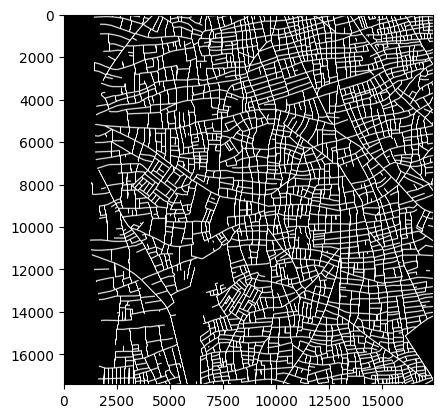

In [14]:
import matplotlib.pyplot as plt

# Visualize the array
plt.imshow(road_mask, cmap='gray')
plt.show()

In [ ]:
segment_utils.rmv_mask_overlap()

In [51]:
cv = np.load('/home/vaschetti/maxarSrc/output/canvas.npy')
cv.shape

(3, 17408, 17408)

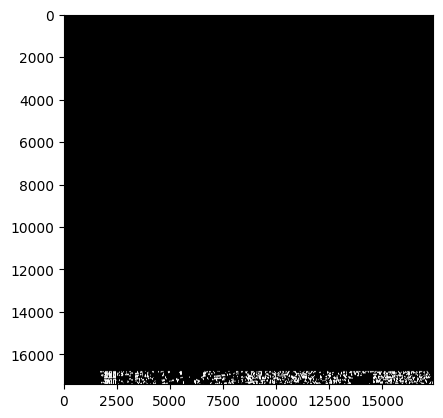

In [45]:
import matplotlib.pyplot as plt

# Visualize the array
plt.imshow(canvas[1], cmap='gray')
plt.show()

In [12]:
output.single_mask2Tif(m0.tiles_paths[17], canvas[1], 'test_build_2.tif')

Mask written in /home/vaschetti/maxarSrc/output/test_build_2.tif


In [21]:
def single_mask2Tif(tile_path, mask, out_name, out_path_root = '/home/vaschetti/maxarSrc/output'):
    with rasterio.open(tile_path) as src:
        out_meta = src.meta.copy()
    
    out_meta.update({"driver": "GTiff",
                     "dtype": "uint8",
                     "count": 1})
    out_path = out_path_root + '/'+ out_name
    with rasterio.open(out_path, 'w', **out_meta) as dest:
            dest.write(mask, 1)

In [22]:
single_mask2Tif(m0.tiles_paths[17], canvas[0], 'test_trees.tif')

In [ ]:
#Top, working

self = m0
tile_path = m0.tiles_paths[17]

seg_config = self.event.seg_config
dataset = geoDatasets.Maxar(str(tile_path))
sampler = samplers.MyBatchGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

canvas = np.zeros((seg_config.size, seg_config.size, 3), dtype=np.uint8)
i = 0
f_i = 2
for batch in tqdm(dataloader):
    i+=1
    """if i != f_i:
        i+=1
        continue"""
    original_img_tsr = batch['image']
    img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor
    
    #get the tree boxes in batches and the number of trees for each image
    tree_boxes_b, num_trees4img = detect.get_GD_boxes(img_b, seg_config.GD_model,
                                        seg_config.TEXT_PROMPT,
                                        seg_config.BOX_THRESHOLD,
                                        seg_config.TEXT_THRESHOLD,
                                        dataset.res,
                                        device = seg_config.device,
                                        max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
    
    #get the building boxes in batches and the number of buildings for each image
    building_boxes_b, num_build4img = detect.get_batch_buildings_boxes(batch['bbox'],
                                                                proj_buildings_gdf = self.proj_build_gdf,
                                                                dataset_res = dataset.res,
                                                                ext_mt = 10)
    max_detect = max(num_trees4img + num_build4img)
    print("\n__________________________")
    print("Batch number: ", i)
    print(f'Num detections in batch: {num_trees4img + num_build4img}')
    
    #obtain the right input for the ESAM model (trees + buildings)
    input_points, input_labels = segment_utils.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
    
    # segment the image and get for each image as many masks as the number of boxes,
    # for GPU constraint use num_parall_queries
    all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                            torch.from_numpy(input_points),
                                            torch.from_numpy(input_labels),
                                            efficient_sam = seg_config.efficient_sam,
                                            device = seg_config.device,
                                            num_parall_queries = 5)
    
    #for each image, discern the masks in trees, buildings and padding
    tree_mask_b, building_mask_b, pad_mask_b = segment_utils.discern(all_masks_b, num_trees4img, num_build4img)
    
    if i == f_i:
        break